In [6]:
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
import sklearn as sk
import numpy as np
import eli5 
hfont = {'fontname':'Helvetica'}

from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate, RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from scipy.stats import loguniform
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import confusion_matrix
from eli5.sklearn import PermutationImportance
from sklearn.inspection import permutation_importance


CIP_data_no_drop = pd.read_csv("CIP_data_encode_prev_not_dropped.csv")


In [10]:
######## auROC by year #############
train_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010])]
oversample = RandomOverSampler(sampling_strategy = 0.5,random_state=42)
years = [2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]

##### collect data for NN - dropped MSW and Midwest

model_nn = MLPClassifier(solver = 'lbfgs', activation = 'tanh', max_iter = 3000 ,hidden_layer_sizes= 12, alpha =1.291549665014884, random_state=10, learning_rate = 'adaptive' )

X_train_nn = train_data[['MSM','MSMW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West', 'PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION']]
y_train_nn = 1 - train_data['Susceptible']

X_train_nn, y_train_nn = oversample.fit_resample(X_train_nn,y_train_nn)

roc_auc_by_year_nn = []
for year in years:
     # test - vary by year dropped MSW and Midwest
     test_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR']== year]
     X_test_nn = test_data[['MSM','MSMW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West', 'PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION']]
     y_test_nn = 1 - test_data['Susceptible']
     if year == 2019:
          oversample = RandomOverSampler(sampling_strategy = 0.7,random_state=42)

     X_test_nn, y_test_nn = oversample.fit_resample(X_test_nn,y_test_nn)

    # train model 
     model_fit_train = model_nn.fit(X_train_nn, y_train_nn)
     y_predict_test_nn = model_fit_train.predict(X_test_nn)

    #get ROC_AUC (implicit 0.5 threshold)
     roc_auc = metrics.roc_auc_score(y_test_nn, y_predict_test_nn)
     roc_auc_by_year_nn.append(roc_auc)



#### collect data for LR - drop west and southeast

model_lr = LogisticRegression(class_weight = 'balanced', max_iter=4000, solver = "lbfgs", C = 0.27, penalty = 'l2')

#   train 
X_train_lr = train_data[['MSM','MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southwest',  'Midwest','PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION']]
y_train_lr = 1 - train_data['Susceptible']

roc_auc_by_year_lr = []
for year in years:
     # test - vary by year dropped MSW and Midwest
     test_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR']== year]
     X_test_lr = test_data[['MSM','MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southwest',  'Midwest','PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION']]
     y_test_lr = 1 - test_data['Susceptible']

    # train model 
     model_fit_train = model_lr.fit(X_train_lr, y_train_lr)
     y_predict_test_lr = model_fit_train.predict(X_test_lr)

    #get ROC_AUC (implicit 0.5 threshold)
     roc_auc = metrics.roc_auc_score(y_test_lr, y_predict_test_lr)
     roc_auc_by_year_lr.append(roc_auc)


#### collect data for RF - dropped  prev_region, southwest, northeast

model_rf = RandomForestClassifier(n_estimators = 171, min_samples_split = 1, min_samples_leaf=1, max_features = 'sqrt', max_depth = 89, random_state = 10)

feature_names = ['MSM','MSMW', 'MSW', 'Oth/Unk/Missing','Southeast',  'West', 'Midwest','PREV_CLINIC', 'DELTA_REGION']
#   train 
train_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010])]
X_train_rf = train_data[feature_names]
y_train_rf = 1 - train_data['Susceptible']
X_train_rf, y_train_rf = oversample.fit_resample(X_train_rf,y_train_rf)


roc_auc_by_year_rf = []
for year in years:
     # test - vary by year dropped MSW and Midwest
     test_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR']== year]
     X_test_rf = test_data[feature_names]
     y_test_rf = 1 - test_data['Susceptible']

    # train model 
     model_fit_train = model_lr.fit(X_train_rf, y_train_rf)
     y_predict_test_rf = model_fit_train.predict(X_test_rf)

    #get ROC_AUC (implicit 0.5 threshold)
     roc_auc = metrics.roc_auc_score(y_test_rf, y_predict_test_rf)
     roc_auc_by_year_rf.append(roc_auc)




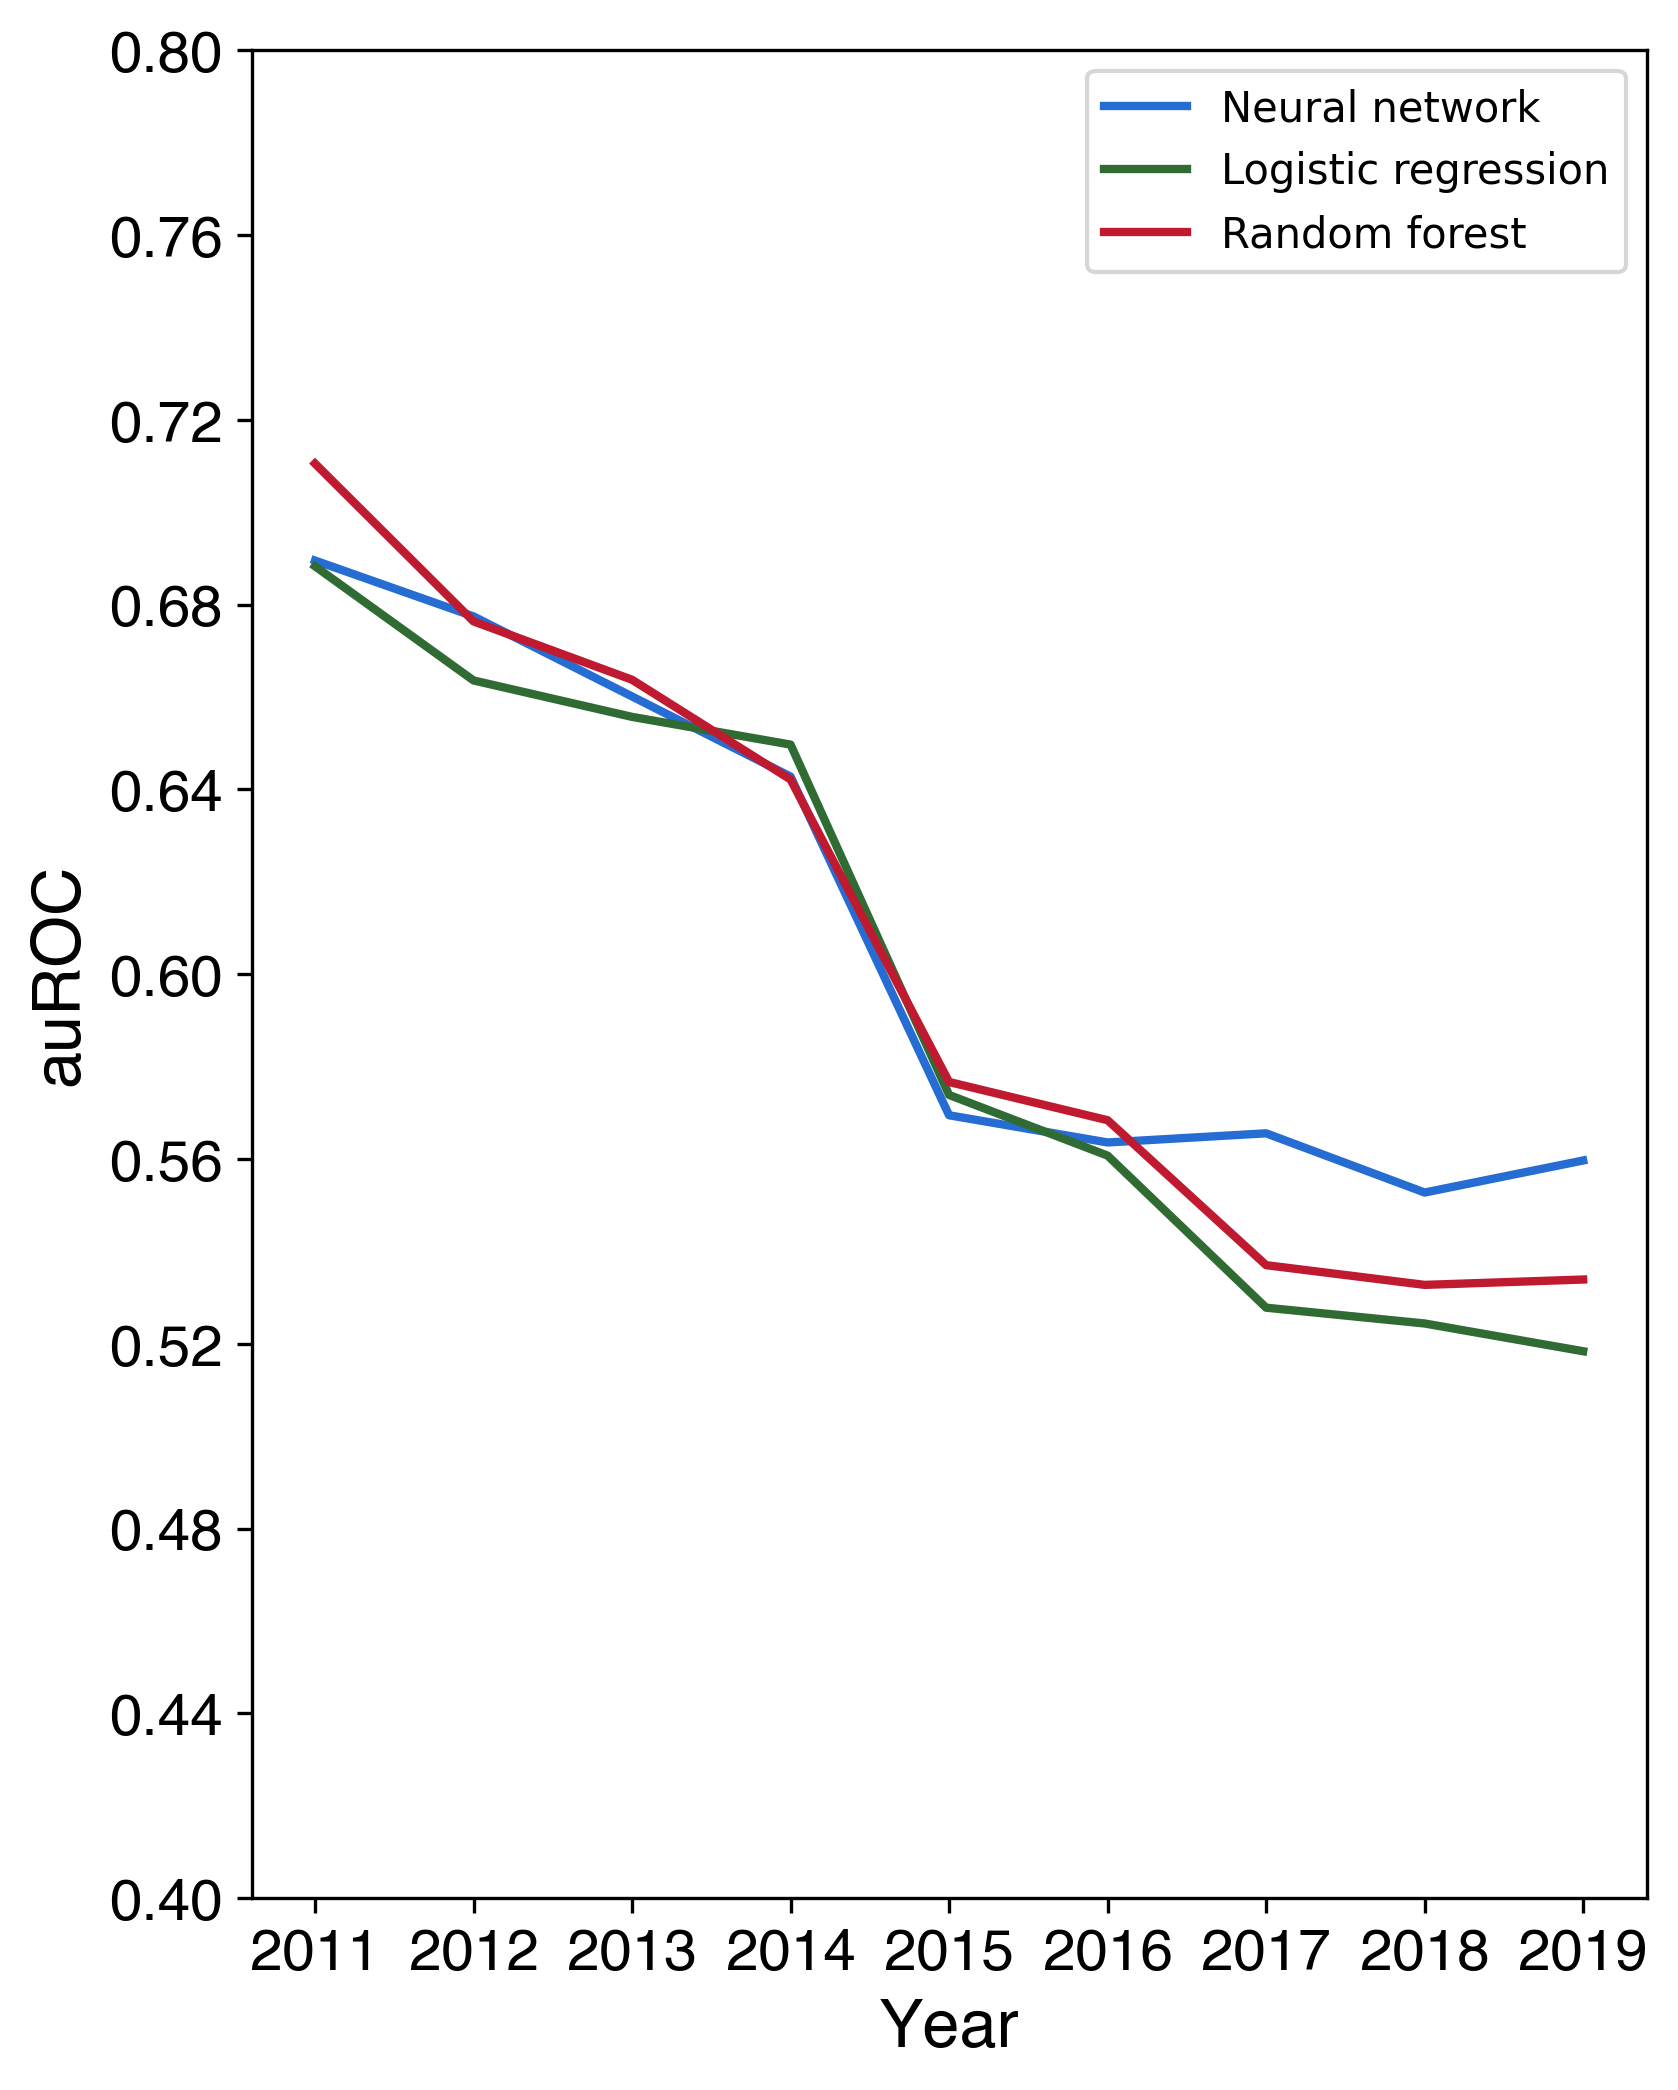

In [15]:
######### Efficiency of model different datasets - GRAPH 
years = [2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
plt.plot(years, roc_auc_by_year_nn, color = "#266DD3", linestyle = 'solid', linewidth = 2, label = "Neural network")
plt.plot(years, roc_auc_by_year_lr, color = "#306B34", linestyle = 'solid', linewidth = 2, label = "Logistic regression")
plt.plot(years, roc_auc_by_year_rf, color = "#BF1A2F", linestyle = 'solid', linewidth = 2, label = "Random forest")

plt.xlabel("Year", fontsize=16,**hfont)
plt.ylabel("auROC", fontsize=16,**hfont)
plt.xticks(years, fontsize=14,**hfont)
plt.yticks(np.linspace(0.4,0.8,11), fontsize=14,**hfont)
plt.ylim([0.4,0.8])

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = [6,8]
plt.legend()
plt.savefig('Graphs/auROC_single_test_years_all_workflow_paper_all_models.png')

In [9]:
print(roc_auc_by_year_lr)

[0.759304650587546, 0.759304650587546, 0.759304650587546, 0.759304650587546, 0.759304650587546, 0.759304650587546, 0.759304650587546, 0.759304650587546, 0.759304650587546]
